In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split,\
                                    cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from scipy.stats import randint, uniform
from sklearn.linear_model import LinearRegression

Перед вами датасет, описывающий поступление детей в колледж. Целевая переменная in_college

1. Осмотрите данные.
2. Примените для предобработки пайплайн с прошлого урока.
3. Решите задачу классификации методами:
   - логистической регрессии
   - линейной классификации
   - деревом решений
   - методом опорных векторов
4. Сравните полученные в каждом решении метрики между собой
Попробуйте использовать GridSearch для поиска оптимальных гиперпараметров, перечисленных выше алгоритмов.

In [79]:
df = pd.read_csv("data.csv")

In [80]:
df

,type_school,school_accreditation,gender,interest,residence,parent_age,parent_salary,house_area,average_grades,parent_was_in_college,in_college
0,Academic,A,Male,Less Interested,Urban,56,6950000,83.0,84.09,False,True
1,Academic,A,Male,Less Interested,Urban,57,4410000,76.8,86.91,False,True
2,Academic,B,Female,Very Interested,Urban,50,6500000,80.6,87.43,False,True
3,Vocational,B,Male,Very Interested,Rural,49,6600000,78.2,82.12,True,True
4,Academic,A,Female,Very Interested,Urban,57,5250000,75.1,86.79,False,False
...,...,...,...,...,...,...,...,...,...,...,...
995,Vocational,A,Female,Very Interested,Rural,49,7420000,63.6,85.99,True,True
996,Academic,B,Female,Less Interested,Rural,51,7480000,84.3,89.72,True,True
997,Vocational,A,Male,Less Interested,Urban,49,5550000,75.2,79.56,False,True
998,Academic,B,Male,Uncertain,Rural,53,5840000,105.8,87.18,True,True


In [81]:
df['interest'].value_counts()

Very Interested     324
Uncertain           261
Less Interested     229
Quiet Interested    100
Not Interested       86
Name: interest, dtype: int64

In [82]:
df['in_college'].value_counts()

True     500
False    500
Name: in_college, dtype: int64

In [83]:
df['type_school'].value_counts()

Academic      609
Vocational    391
Name: type_school, dtype: int64

In [84]:
df.groupby('type_school')['in_college'].mean()

type_school
Academic      0.513957
Vocational    0.478261
Name: in_college, dtype: float64

In [85]:
df.groupby("type_school").aggregate({'in_college': "mean"})

,in_college
type_school,
Academic,0.513957
Vocational,0.478261


In [86]:
df.groupby("school_accreditation").aggregate({'in_college': "mean"})

,in_college
school_accreditation,
A,0.515593
B,0.485549


In [87]:
df.groupby("residence").aggregate({'in_college': "mean"})

,in_college
residence,
Rural,0.496746
Urban,0.502783


In [88]:
df.groupby("parent_was_in_college").aggregate({'in_college': "mean"})

,in_college
parent_was_in_college,
False,0.475000
True,0.523077


In [89]:
df.groupby("interest").aggregate({'in_college': "mean"}).sort_values(by='in_college')

,in_college
interest,
Quiet Interested,0.190000
Less Interested,0.379913
Not Interested,0.534884
Very Interested,0.586420
Uncertain,0.605364


Выводы: 
Зависимости особо нет между категориальными признаками и целевой переменной (поступившими и не поступившими). Почти везде распределение поступивших и не поступивших пополам
Не уверенные поступают чаще, чем очень заинтерисованные. Странно

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   type_school            1000 non-null   object 
 1   school_accreditation   1000 non-null   object 
 2   gender                 1000 non-null   object 
 3   interest               1000 non-null   object 
 4   residence              1000 non-null   object 
 5   parent_age             1000 non-null   int64  
 6   parent_salary          1000 non-null   int64  
 7   house_area             1000 non-null   float64
 8   average_grades         1000 non-null   float64
 9   parent_was_in_college  1000 non-null   bool   
 10  in_college             1000 non-null   bool   
dtypes: bool(2), float64(2), int64(2), object(5)
memory usage: 72.4+ KB


Датафрейм содержит 1000 записей. Пропусков нет

In [91]:
df.describe()

,parent_age,parent_salary,house_area,average_grades
count,1000.000000,1.000000e+03,1000.000000,1000.000000
mean,52.208000,5.381570e+06,74.515300,86.097200
std,3.500427,1.397546e+06,15.293346,3.378738
min,40.000000,1.000000e+06,20.000000,75.000000
25%,50.000000,4.360000e+06,64.600000,83.737500
50%,52.000000,5.440000e+06,75.500000,85.575000
75%,54.000000,6.382500e+06,84.825000,88.262500
max,65.000000,1.000000e+07,120.000000,98.000000


In [92]:
x = df.drop(['in_college'], axis = 1)

In [93]:
y = df['in_college']

In [94]:
x

,type_school,school_accreditation,gender,interest,residence,parent_age,parent_salary,house_area,average_grades,parent_was_in_college
0,Academic,A,Male,Less Interested,Urban,56,6950000,83.0,84.09,False
1,Academic,A,Male,Less Interested,Urban,57,4410000,76.8,86.91,False
2,Academic,B,Female,Very Interested,Urban,50,6500000,80.6,87.43,False
3,Vocational,B,Male,Very Interested,Rural,49,6600000,78.2,82.12,True
4,Academic,A,Female,Very Interested,Urban,57,5250000,75.1,86.79,False
...,...,...,...,...,...,...,...,...,...,...
995,Vocational,A,Female,Very Interested,Rural,49,7420000,63.6,85.99,True
996,Academic,B,Female,Less Interested,Rural,51,7480000,84.3,89.72,True
997,Vocational,A,Male,Less Interested,Urban,49,5550000,75.2,79.56,False
998,Academic,B,Male,Uncertain,Rural,53,5840000,105.8,87.18,True


In [95]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   type_school            1000 non-null   object 
 1   school_accreditation   1000 non-null   object 
 2   gender                 1000 non-null   object 
 3   interest               1000 non-null   object 
 4   residence              1000 non-null   object 
 5   parent_age             1000 non-null   int64  
 6   parent_salary          1000 non-null   int64  
 7   house_area             1000 non-null   float64
 8   average_grades         1000 non-null   float64
 9   parent_was_in_college  1000 non-null   bool   
dtypes: bool(1), float64(2), int64(2), object(5)
memory usage: 71.4+ KB


In [96]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1000 entries, 0 to 999
Series name: in_college
Non-Null Count  Dtype
--------------  -----
1000 non-null   bool 
dtypes: bool(1)
memory usage: 1.1 KB


In [97]:
x[x.select_dtypes(include="bool").columns] = \
    x[x.select_dtypes(include="bool").columns].astype("int64")

In [98]:
y = y.map({False:0, True:1})

In [99]:
# Cформируем перечни колонок в зависимости от типов.
numeric_features = x.select_dtypes(include=['int64', 'float64']).columns
categorical_features = x.select_dtypes(include=['object']).columns
bool_features = x.select_dtypes(include=['bool']).columns

In [100]:
numeric_features

Index(['parent_age', 'parent_salary', 'house_area', 'average_grades',
       'parent_was_in_college'],
      dtype='object')

In [101]:
categorical_features

Index(['type_school', 'school_accreditation', 'gender', 'interest',
       'residence'],
      dtype='object')

In [102]:
bool_features

Index([], dtype='object')

<AxesSubplot:>

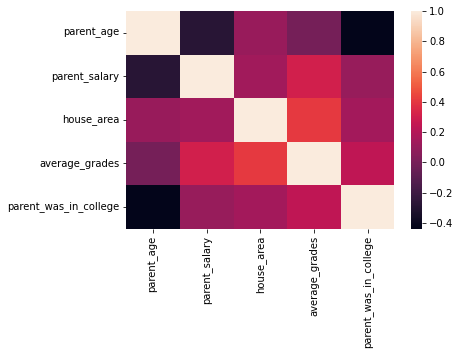

In [103]:
sns.heatmap(x.corr()) #черная высокая корреляция отриц, белая высокая корр положит

In [104]:
x.corr()

,parent_age,parent_salary,house_area,average_grades,parent_was_in_college
parent_age,1.000000,-0.286418,0.107060,-0.006077,-0.438322
parent_salary,-0.286418,1.000000,0.138357,0.306712,0.106487
house_area,0.107060,0.138357,1.000000,0.409565,0.145186
average_grades,-0.006077,0.306712,0.409565,1.000000,0.236713
parent_was_in_college,-0.438322,0.106487,0.145186,0.236713,1.000000


In [105]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   type_school            1000 non-null   object 
 1   school_accreditation   1000 non-null   object 
 2   gender                 1000 non-null   object 
 3   interest               1000 non-null   object 
 4   residence              1000 non-null   object 
 5   parent_age             1000 non-null   int64  
 6   parent_salary          1000 non-null   int64  
 7   house_area             1000 non-null   float64
 8   average_grades         1000 non-null   float64
 9   parent_was_in_college  1000 non-null   int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 78.2+ KB


Выводы. Есть зависимость между площадью дома и оценкой, а также зависимость между доходом родителей и оценкой

**2. Примените для предобработки пайплайн с прошлого урока**

In [126]:
from sklearn import model_selection
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, random_state=0)

In [127]:
x_train

,type_school,school_accreditation,gender,interest,residence,parent_age,parent_salary,house_area,average_grades,parent_was_in_college
253,Academic,B,Female,Very Interested,Urban,56,6070000,71.3,86.86,0
667,Academic,A,Female,Quiet Interested,Urban,49,7450000,92.6,83.55,0
85,Vocational,B,Female,Quiet Interested,Urban,56,5280000,56.0,88.38,0
969,Academic,B,Male,Uncertain,Urban,53,5920000,63.7,87.52,1
75,Vocational,B,Female,Quiet Interested,Urban,55,4200000,51.2,84.02,0
...,...,...,...,...,...,...,...,...,...,...
835,Academic,A,Male,Uncertain,Urban,51,7650000,64.2,87.03,0
192,Vocational,A,Male,Uncertain,Rural,52,5620000,74.9,85.15,0
629,Vocational,A,Female,Very Interested,Urban,53,5700000,75.5,83.64,0
559,Academic,B,Male,Very Interested,Rural,50,3180000,72.4,85.01,1


In [128]:
y_train

253    1
667    1
85     0
969    1
75     0
      ..
835    1
192    0
629    1
559    0
684    1
Name: in_college, Length: 750, dtype: int64

In [129]:
# Create a numeric and categorical transformer to perform preprocessing steps
# Создайте числовой и категориальный преобразователь для выполнения шагов предварительной обработки. Бинарные признаки и у обрабатывать не нужно
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


In [130]:
# Use the ColumnTransformer to apply to the correct features
# Используйте Column Transformer, чтобы применить к правильным функциям
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [131]:
x_train = preprocessor.fit_transform(x_train)

In [132]:
#логистическая регрессия
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state = 42)

score_logreg = cross_val_score(logreg, x_train, y_train, cv=5, scoring='roc_auc') 
score_logreg, score_logreg.mean()

(array([0.91537778, 0.93706667, 0.95394737, 0.95874822, 0.93225462]),
 0.9394789315631421)

In [133]:
logreg_params  = {"penalty": ["l1", "l2", "elasticnet"],
                       "C": range(1, 10)}

logreg_grid = GridSearchCV(logreg, logreg_params, cv=5, scoring='roc_auc' )
logreg_grid.fit(x_train, y_train)
logreg_grid.best_params_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
90 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Val

{'C': 3, 'penalty': 'l2'}

In [134]:
#линейная классификация
from sklearn.linear_model import SGDClassifier
SGDclf = SGDClassifier(random_state = 42)

score_SGDclf = cross_val_score(SGDclf, x_train, y_train, cv=5, scoring='roc_auc') 
score_SGDclf, score_SGDclf.mean()

(array([0.88142222, 0.91768889, 0.91927454, 0.94114509, 0.92674253]),
 0.9172546546546547)

In [135]:
SGDclf_params  = {"penalty": ["l1", "l2", "elasticnet"],
                  "alpha": [0.0001, 0.001, 0.01],
                 "max_iter": [1000, 5000, 10000]}

SGDclf_grid = GridSearchCV(SGDclf, SGDclf_params, cv=5, n_jobs=-1)
SGDclf_grid.fit(x_train, y_train)
SGDclf_grid.best_params_

{'alpha': 0.001, 'max_iter': 1000, 'penalty': 'l1'}

In [136]:
#дерево решений
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state = 42)

score_clf = cross_val_score(clf, x_train, y_train, cv=5, scoring='roc_auc') 
score_clf, score_clf.mean()

(array([0.80666667, 0.84      , 0.83997155, 0.8730441 , 0.83943812]),
 0.8398240872451398)

In [137]:
clf_params  = {'max_depth': range(1,11), 'max_features': range(3,19)}

clf_grid = GridSearchCV(clf, clf_params, cv=5, verbose=True, scoring='roc_auc')
clf_grid.fit(x_train, y_train)
clf_grid.best_params_

Fitting 5 folds for each of 160 candidates, totalling 800 fits


{'max_depth': 5, 'max_features': 15}

In [138]:
#метод опорных векторов
from sklearn.svm import SVC
svc = SVC(random_state = 42)
svc = Pipeline(steps=[('classifier', svc)])

score_svc = cross_val_score(svc, x_train, y_train, cv=5, scoring='roc_auc') 
score_svc, score_svc.mean()

(array([0.95928889, 0.97173333, 0.98310811, 0.96906117, 0.97083926]),
 0.9708061514145724)

In [139]:
svc_params  = {"classifier__degree": [2, 3, 4],
                       "classifier__kernel": ["linear", "poly", "rbf", "sigmoid"],
                       "classifier__C": [1, 10, 15, 100]}
svc_grid = GridSearchCV(svc, svc_params, cv=5, verbose=True, scoring='roc_auc')
svc_grid.fit(x_train, y_train)
svc_grid.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'classifier__C': 10, 'classifier__degree': 2, 'classifier__kernel': 'poly'}